# train


In [1]:

ERRORTYPE = "Backing"
PART = "1"
TYPE = "adult"  # adult child mix
model_name = "EfficientNetV2B0"  # 'MobileNetV2' 'EfficientNetV2B0'

print(model_name)
DATE = 'exp0922_0401_0707'
mission = DATE+'_'+ERRORTYPE+'_part_'+PART+'_'+TYPE+'_'+model_name
print(mission)


EfficientNetV2B0
exp0922_0401_0707_Backing_part_1_adult_EfficientNetV2B0


In [2]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import sys
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import mixed_precision
from IPython.display import Audio
import librosa
from sklearn.metrics import confusion_matrix
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

from skimage.transform import resize


2022-09-24 21:01:45.444685: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
TF_ENABLE_ONEDNN_OPTS=0

In [4]:
sr = 16000


if(ERRORTYPE == 'Backing'):
    NPDATA_PATH = '../exp/binear_classification/npzdata/Backing-error/0401_0916/Backing_0_1_data0401_0916_' + \
        TYPE+'_part_'+PART+'.npz'
elif(ERRORTYPE == 'Stoping'):
    NPDATA_PATH = '../exp/binear_classification/npzdata/Stoping-error/0401_0916/Stoping_0_1_data0401_0916_' + \
        TYPE+'_part_'+PART+'.npz'



SEED = 42
def plot_time_series(data, sr):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, len(data)/sr, len(data)), data)
    plt.show()


In [5]:
x = np.load(NPDATA_PATH, mmap_mode='r', allow_pickle=True)
X_train = x['X_train']
y_train = x['y_train']
X_test = x['X_test']
y_test = x['y_test']

In [6]:
classes = np.unique(y_train)
total = len(y_train)
for c in classes:
	n_examples = len(y_train[y_train == c])
	percent = n_examples / total * 100
	print(f'> Class={c} : {n_examples}/{total} {percent}%')

> Class=0 : 494/1455 33.95189003436426%
> Class=16 : 961/1455 66.04810996563573%


In [7]:
classes = np.unique(y_test)
total = len(y_test)
for c in classes:
	n_examples = len(y_test[y_test == c])
	percent = n_examples / total * 100
	print(f'> Class={c} : {n_examples}/{total} {percent}%')


> Class=0 : 248/728 34.065934065934066%
> Class=16 : 480/728 65.93406593406593%


## change class

In [8]:
for c in classes:
    if c == 0:
        y_train[y_train == c] = 1 
        y_test[y_test == c] = 1 
    elif c == 16:
        y_train[y_train == c] = 0
        y_test[y_test == c] = 0

In [9]:
classes = np.unique(y_train)
total = len(y_train)
print(f"training")
for c in classes:
    n_examples = len(y_train[y_train == c])
    percent = n_examples / total * 100
    print(f'> Class={c} : {n_examples}/{total} {percent}%')


training
> Class=0 : 961/1455 66.04810996563573%
> Class=1 : 494/1455 33.95189003436426%


In [10]:
classes = np.unique(y_test)
total = len(y_test)
print(f"testing")
for c in classes:
    n_examples = len(y_test[y_test == c])
    percent = n_examples / total * 100
    print(f'> Class={c} : {n_examples}/{total} {percent}%')


testing
> Class=0 : 480/728 65.93406593406593%
> Class=1 : 248/728 34.065934065934066%


## data augmentation

In [11]:
# minority_data = X_train[y_train == 1]
# minority_label = y_train[y_train == 1]
minority_data = X_train
minority_label = y_train


In [12]:
minority_data.shape


(1455, 32000)

In [13]:
minority_label.shape


(1455,)

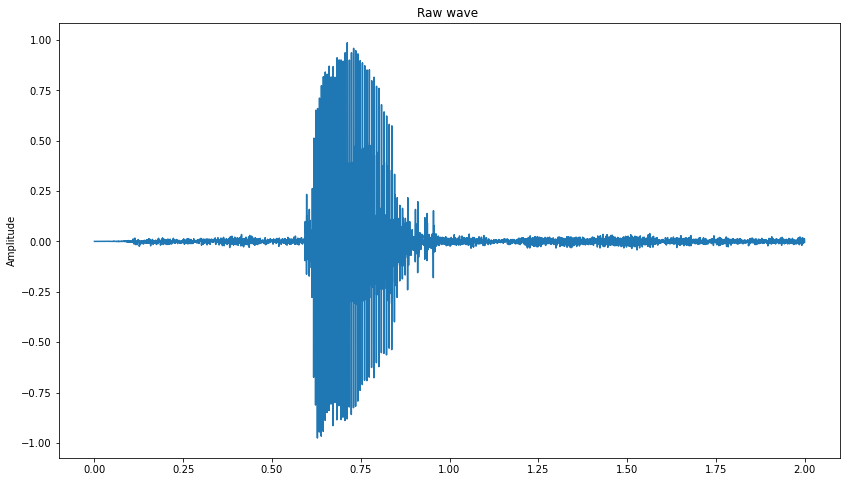

In [14]:
plot_time_series(minority_data[0], sr)
Audio(minority_data[0], rate=sr)

In [15]:


augment1 = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1)
    # TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    # PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    # Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])
augment2 = Compose([
    # AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)
    TimeStretch(min_rate=0.8, max_rate=1.25, p=1)
    # PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    # Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

augment3 = Compose([
    # AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)
    # TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5)
    PitchShift(min_semitones=-4, max_semitones=4, p=1),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=1)
])

augment4 = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.2, max_fraction=0.2, p=0.5)
])

# Generate 2 seconds of dummy audio for the sake of example
# samples = np.random.uniform(
#     low=-0.2, high=0.2, size=(32000,)).astype(np.float32)

# Augment/transform/perturb the audio data
augmented_sample1 = augment1(samples=minority_data, sample_rate=sr)
augmented_sample2 = augment2(samples=minority_data, sample_rate=sr)
augmented_sample3 = augment3(samples=minority_data, sample_rate=sr)
augmented_sample4 = augment4(samples=minority_data, sample_rate=sr)


In [16]:
print(f"augmented_sample1.shape: {augmented_sample1.shape}")
print(f"augmented_sample2.shape: {augmented_sample2.shape}")
print(f"augmented_sample3.shape: {augmented_sample3.shape}")
print(f"augmented_sample4.shape: {augmented_sample4.shape}")


augmented_sample1.shape: (1455, 32000)
augmented_sample2.shape: (1455, 32000)
augmented_sample3.shape: (1455, 32000)
augmented_sample4.shape: (1455, 32000)


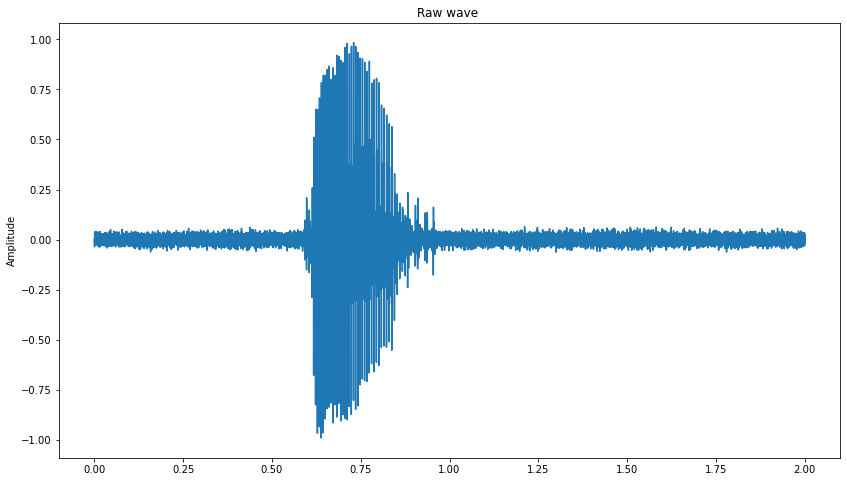

In [17]:

plot_time_series(augmented_sample1[0], sr)
Audio(augmented_sample1[0], rate=sr)


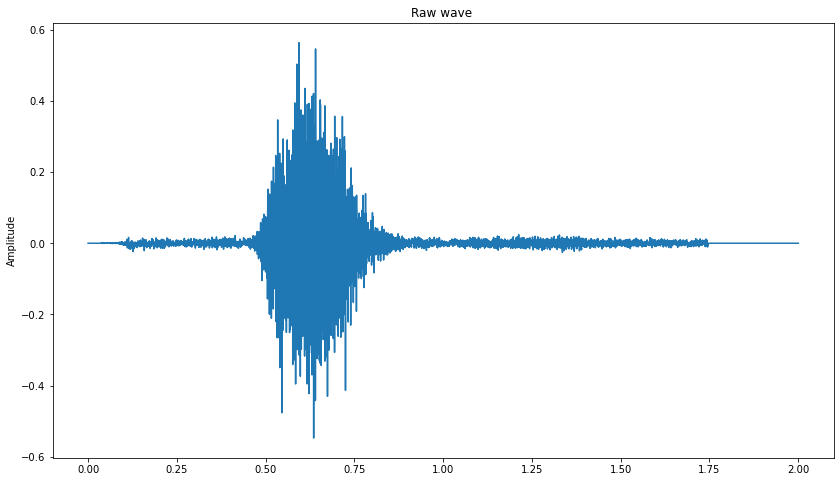

In [18]:
plot_time_series(augmented_sample2[0], sr)
Audio(augmented_sample2[0], rate=sr)

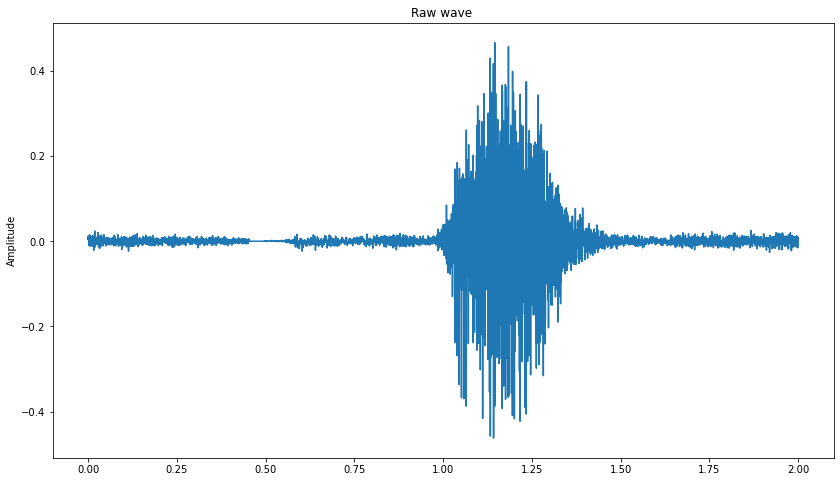

In [19]:
plot_time_series(augmented_sample3[0], sr)
Audio(augmented_sample3[0], rate=sr)

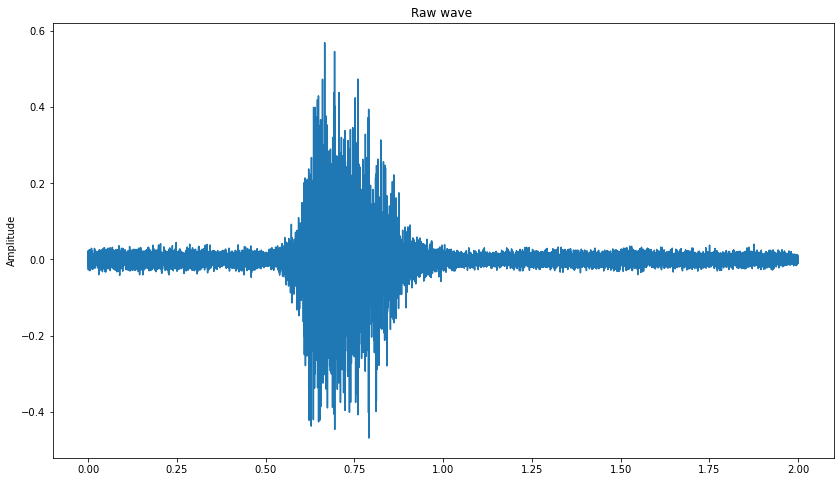

In [20]:
plot_time_series(augmented_sample4[0], sr)
Audio(augmented_sample4[0], rate=sr)

In [21]:
X_train = np.concatenate(
    [X_train, augmented_sample1, augmented_sample2, augmented_sample3, augmented_sample4], axis=0)
y_train = np.concatenate(
    [y_train, minority_label, minority_label, minority_label, minority_label], axis=0)
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")



X_train.shape: (7275, 32000)
y_train.shape: (7275,)


## Random train

In [22]:
order = np.arange(len(y_train))
np.random.seed(SEED)
np.random.shuffle(order)
X_train = X_train[order]
y_train = y_train[order]
X_train.shape


(7275, 32000)

## processing

In [23]:
from skimage.transform import resize
def get_3ch_spectrum(wav,sr):
    feature_size = 128
    num_channels = 3
    window_sizes = [25, 50, 100]
    hop_sizes = [10, 25, 50]
    normalizedy = librosa.util.normalize(wav)
    specs = []
    for i in range(num_channels):
        window_length = int(round(window_sizes[i]*sr/1000))
        # print('win_len: ',window_length)
        hop_length = int(round(hop_sizes[i]*sr/1000))
        mel = librosa.feature.melspectrogram(
            y=normalizedy, sr=sr, n_fft=4410, hop_length=hop_length, win_length=window_length, n_mels=128)
        mellog = np.log(mel + 1e-6)
        # print(mellog)
        # spec = librosa.util.normalize(mellog)
        spec = resize(mellog, (128, feature_size))
        spec = np.asarray(spec)
        specs.append(spec)
    # list to np array
    specs = np.asarray(specs)
    specs = np.moveaxis(specs, 0, 2)
#     print('specs.shape : ', specs.shape)
    return specs




In [24]:
train_specs = []
for i in range (X_train.shape[0]):
    spec = get_3ch_spectrum(X_train[i],sr)
    train_specs.append(spec)
X_train = np.asarray(train_specs)

In [25]:
test_specs = []
for i in range (X_test.shape[0]):
    spec = get_3ch_spectrum(X_test[i],sr)
    test_specs.append(spec)
X_test = np.asarray(test_specs)

## model

In [26]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
import tensorflow as tf
import datetime
import tempfile


In [27]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


## Define the model and metrics

In [28]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


def make_model(metrics=METRICS, output_bias=None):
      if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)

      if(model_name == 'MobileNetV2'):
            base_model = tf.keras.applications.MobileNetV2(
            include_top=False,
            weights="imagenet",
            input_shape=(128, 128, 3),
            )
      elif(model_name == 'EfficientNetV2B0'):
            base_model = tf.keras.applications.EfficientNetV2B0(
            include_top=False,
            weights="imagenet",
            input_shape=(128, 128, 3),
            )
      base_model.trainable = True
      inputs = keras.Input(shape=(128, 128, 3))
      inputs = keras.layers.BatchNormalization()(inputs)
      x = base_model(inputs, training=True)
      x = keras.layers.GlobalAveragePooling2D()(x)
      x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
      x = keras.layers.Dense(512, activation='relu')(x)
      outputs = keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)
      model = keras.Model(inputs, outputs)
      model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=1e-3),
          loss=keras.losses.BinaryCrossentropy(),
          metrics=METRICS)
      return model





2022-09-24 21:04:55.471200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 21:04:55.474472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 21:04:55.474582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 21:04:55.475062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

### Baseline model

In [29]:
EPOCHS = 50
BATCH_SIZE = 32
output_bias = None

if(ERRORTYPE == 'Backing'):
    SAVE_PATH = '../exp/binear_classification/Backing-error/'+DATE+'/weight/'

    if(TYPE == 'mix'):
        dataset = 'Backing-mix-baseline'
    elif(TYPE == 'adult'):
        dataset = 'Backing-adult-baseline'
    elif(TYPE == 'child'):
        dataset = 'Backing-child-baseline'
    NAME = model_name+'_'+dataset+'_bs'+str(BATCH_SIZE)+'_data_' + 'part'+PART+'_' + \
        datetime.datetime.now().strftime("%m%d_%H%M")
    log_dir = '../exp/binear_classification/Backing-error/'+DATE+'/logs/' + NAME
elif(ERRORTYPE == 'Stoping'):
    SAVE_PATH = '../exp/binear_classification/Stoping-error/'+DATE+'/weight/'
    if(TYPE == 'mix'):
        dataset = 'Stoping-mix-baseline'
    elif(TYPE == 'adult'):
        dataset = 'Stoping-adult-baseline'
    elif(TYPE == 'child'):
        dataset = 'Stoping-child-baseline'
    NAME = model_name+'_'+dataset+'_bs'+str(BATCH_SIZE)+'_data_' + 'part'+PART+'_' + \
        datetime.datetime.now().strftime("%m%d_%H%M")
    log_dir = '../exp/binear_classification/Stoping-error/'+DATE+'/logs/' + NAME


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_ckpt = ModelCheckpoint(
            SAVE_PATH + NAME +
            '_{epoch:02d}-{val_precision:.2f}-{val_recall:.2f}.hdf5',
            monitor='val_recall',
            mode='max',
            save_freq='epoch',
            verbose=2, 
            save_best_only=True)
es = EarlyStopping(monitor='val_recall', mode='max', verbose=2, restore_best_weights=True, patience=10)
model = make_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 4, 4, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 1)                 513   

In [31]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)


### Train the model

In [32]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        TensorBoard(log_dir=log_dir),
        model_ckpt,
        es
    ],
    validation_data=(X_test, y_test))


Epoch 1/50


2022-09-24 21:05:04.981869: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-09-24 21:05:05.116425: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-24 21:05:05.117429: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-24 21:05:05.117476: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-09-24 21:05:05.118200: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-24 21:05:05.118263: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


228/228 [==============================] - ETA: 0s - loss: 0.5662 - tp: 1317.0000 - fp: 1018.0000 - tn: 3787.0000 - fn: 1153.0000 - accuracy: 0.7016 - precision: 0.5640 - recall: 0.5332 - auc: 0.7414 - prc: 0.5738
Epoch 1: val_recall improved from -inf to 0.36290, saving model to ../exp/binear_classification/Backing-error/exp0922_0401_0707/weight/EfficientNetV2B0_Backing-adult-baseline_bs32_data_part1_0924_2104_01-0.36-0.36.hdf5
228/228 [==============================] - 21s 67ms/step - loss: 0.5662 - tp: 1317.0000 - fp: 1018.0000 - tn: 3787.0000 - fn: 1153.0000 - accuracy: 0.7016 - precision: 0.5640 - recall: 0.5332 - auc: 0.7414 - prc: 0.5738 - val_loss: 0.8710 - val_tp: 90.0000 - val_fp: 163.0000 - val_tn: 317.0000 - val_fn: 158.0000 - val_accuracy: 0.5591 - val_precision: 0.3557 - val_recall: 0.3629 - val_auc: 0.5133 - val_prc: 0.3614
Epoch 2/50
227/228 [============================>.] - ETA: 0s - loss: 0.3948 - tp: 1869.0000 - fp: 709.0000 - tn: 4090.0000 - fn: 596.0000 - accuracy

### Check training history

In [33]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

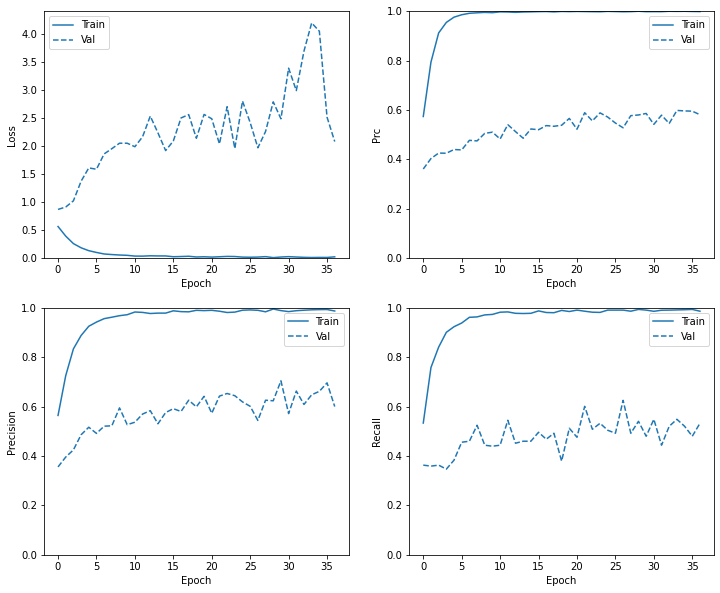

In [34]:
plot_metrics(baseline_history)

### Evaluate metrics


In [35]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

23/23 [==============================] - 0s 14ms/step


In [36]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  2.0032691955566406
tp :  160.0
fp :  136.0
tn :  344.0
fn :  88.0
accuracy :  0.692307710647583
precision :  0.5405405163764954
recall :  0.6451612710952759
auc :  0.7230132818222046
prc :  0.5142186284065247

Legitimate Transactions Detected (True Negatives):  352
Legitimate Transactions Incorrectly Detected (False Positives):  128
Fraudulent Transactions Missed (False Negatives):  93
Fraudulent Transactions Detected (True Positives):  155
Total Fraudulent Transactions:  248


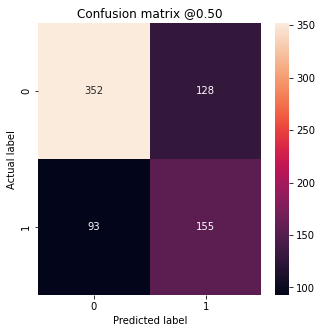

In [37]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

### Plot the ROC


In [38]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

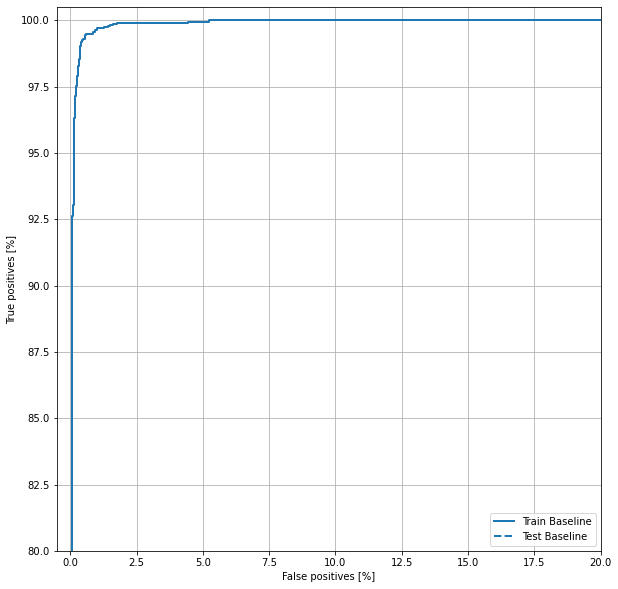

In [39]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC

In [40]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

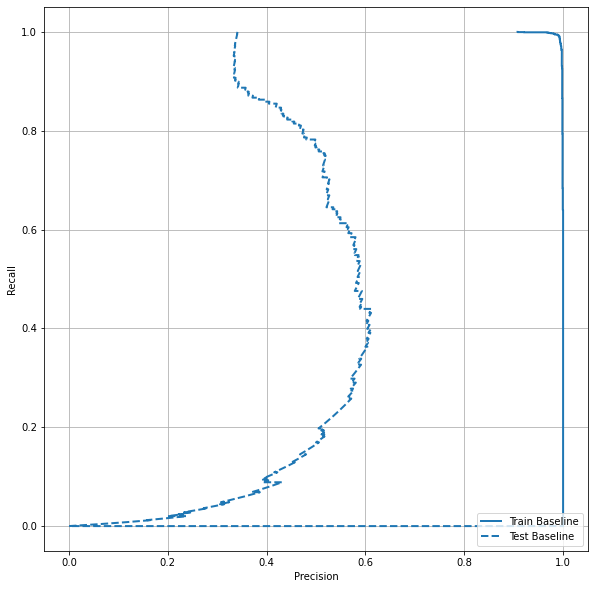

In [41]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

# class_weight

In [42]:
neg, pos = np.bincount(y_train)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 7275
    Positive: 2470 (33.95% of total)



In [43]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.76
Weight for class 1: 1.47


In [44]:
initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)

In [45]:
EPOCHS = 50
BATCH_SIZE = 32
if(ERRORTYPE == 'Backing'):
    SAVE_PATH = '../exp/binear_classification/Backing-error/'+DATE+'/weight/'

    if(TYPE == 'mix'):
        dataset = 'Backing-mix-weighted'
    elif(TYPE == 'adult'):
        dataset = 'Backing-adult-weighted'
    elif(TYPE == 'child'):
        dataset = 'Backing-child-weighted'
    NAME = model_name+'_'+dataset+'_bs'+str(BATCH_SIZE)+'_data_' + 'part'+PART+'_' + \
        datetime.datetime.now().strftime("%m%d_%H%M")
    log_dir = '../exp/binear_classification/Backing-error/'+DATE+'/logs/' + NAME

elif(ERRORTYPE == 'Stoping'):
    SAVE_PATH = '../exp/binear_classification/Stoping-error/'+DATE+'/weight/'
    if(TYPE == 'mix'):
        dataset = 'Stoping-mix-weighted'
    elif(TYPE == 'adult'):
        dataset = 'Stoping-adult-weighted'
    elif(TYPE == 'child'):
        dataset = 'Stoping-child-weighted'

    NAME = model_name+'_'+dataset+'_bs'+str(BATCH_SIZE)+'_data_' + 'part'+PART+'_' + \
        datetime.datetime.now().strftime("%m%d_%H%M")
    log_dir = '../exp/binear_classification/Stoping-error/'+DATE+'/logs/' + NAME


In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


model_ckpt = ModelCheckpoint(
    SAVE_PATH + NAME +
    '_{epoch:02d}-{val_precision:.2f}-{val_recall:.2f}.hdf5',
    monitor='val_recall',
    mode='max',
    save_freq='epoch',
    verbose=2,
    save_best_only=True)
es = EarlyStopping(monitor='val_recall', mode='max',
                   verbose=2, restore_best_weights=True, patience=10)


In [47]:
weighted_model = make_model(output_bias)
weighted_model.load_weights(initial_weights)
weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        TensorBoard(log_dir=log_dir),
        model_ckpt,
        es
    ],
    validation_data=(X_test, y_test),
    # The class weights go here
    class_weight=class_weight)


Epoch 1/50
227/228 [============================>.] - ETA: 0s - loss: 0.5910 - tp: 2008.0000 - fp: 1986.0000 - tn: 3291.0000 - fn: 707.0000 - accuracy: 0.6630 - precision: 0.5028 - recall: 0.7396 - auc: 0.7468 - prc: 0.5758
Epoch 1: val_recall improved from -inf to 0.57661, saving model to ../exp/binear_classification/Backing-error/exp0922_0401_0707/weight/EfficientNetV2B0_Backing-adult-weighted_bs32_data_part1_0924_2113_01-0.36-0.58.hdf5
228/228 [==============================] - 19s 63ms/step - loss: 0.5911 - tp: 2010.0000 - fp: 1989.0000 - tn: 3296.0000 - fn: 708.0000 - accuracy: 0.6630 - precision: 0.5026 - recall: 0.7395 - auc: 0.7468 - prc: 0.5758 - val_loss: 0.9586 - val_tp: 143.0000 - val_fp: 252.0000 - val_tn: 228.0000 - val_fn: 105.0000 - val_accuracy: 0.5096 - val_precision: 0.3620 - val_recall: 0.5766 - val_auc: 0.5185 - val_prc: 0.3698
Epoch 2/50
227/228 [============================>.] - ETA: 0s - loss: 0.4101 - tp: 2099.0000 - fp: 1056.0000 - tn: 3741.0000 - fn: 368.0000

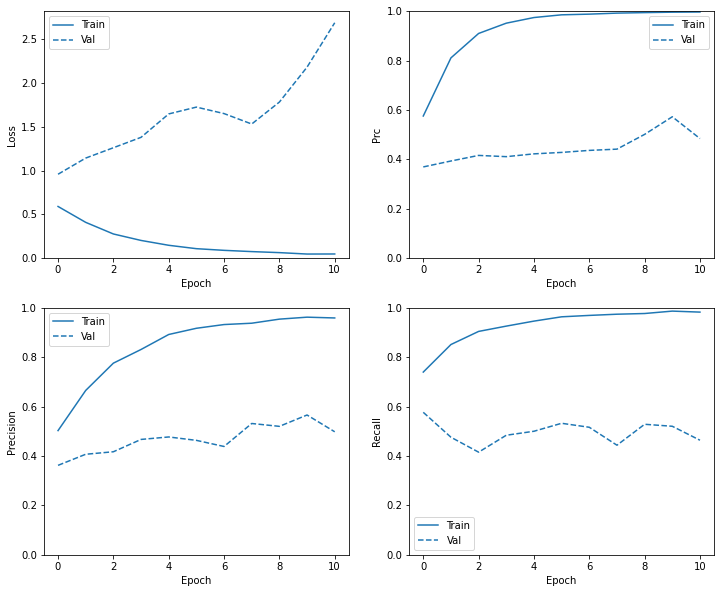

In [48]:
plot_metrics(weighted_history)

In [49]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

23/23 [==============================] - 0s 15ms/step


loss :  0.9642548561096191
tp :  144.0
fp :  250.0
tn :  230.0
fn :  104.0
accuracy :  0.5137362480163574
precision :  0.36548224091529846
recall :  0.5806451439857483
auc :  0.527692437171936
prc :  0.3700888752937317

Legitimate Transactions Detected (True Negatives):  233
Legitimate Transactions Incorrectly Detected (False Positives):  247
Fraudulent Transactions Missed (False Negatives):  110
Fraudulent Transactions Detected (True Positives):  138
Total Fraudulent Transactions:  248


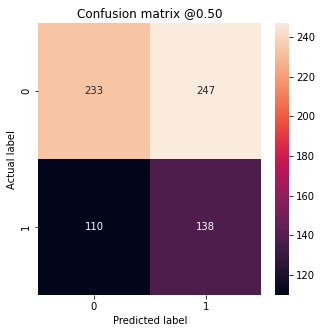

In [50]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

### Plot the ROC

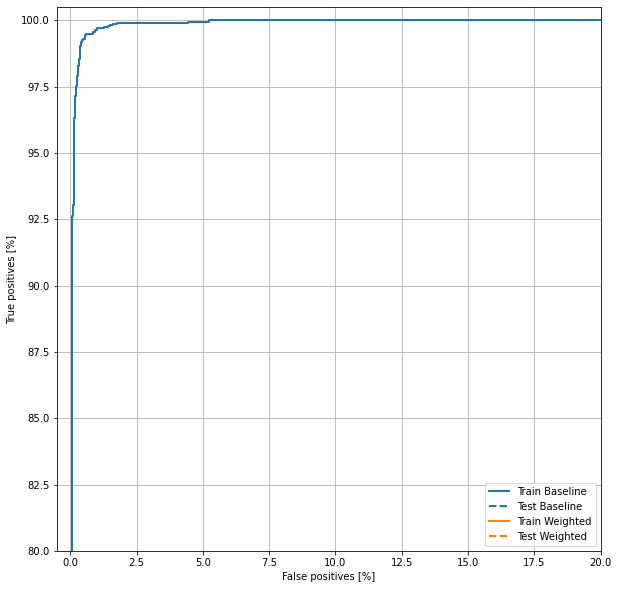

In [51]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline,
         color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted,
         color=colors[1], linestyle='--')


plt.legend(loc='lower right');


plt.legend(loc='lower right');

### Plot the AUPRC

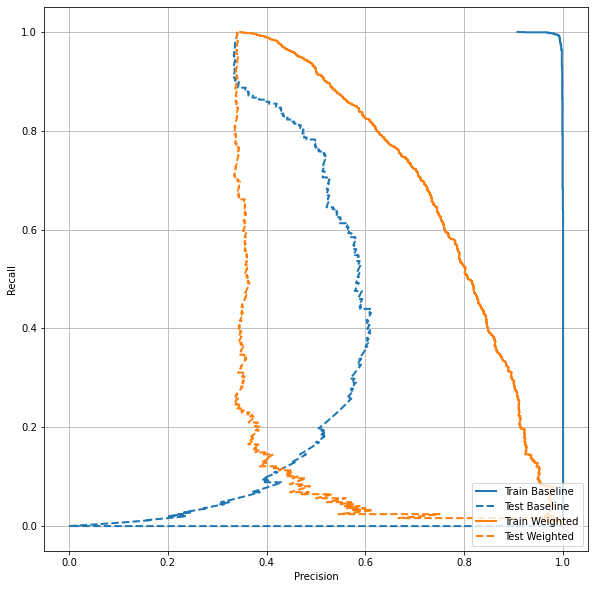

In [52]:
plot_prc("Train Baseline", y_train,
         train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline,
         color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train,
         train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted,
         color=colors[1], linestyle='--')


plt.legend(loc='lower right')


## Oversampling

In [53]:
bool_train_labels = y_train != 0


In [54]:
pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]


In [55]:
pos_features.shape

(2470, 128, 128, 3)

In [56]:
neg_features.shape

(4805, 128, 128, 3)

In [57]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape


(4805, 128, 128, 3)

In [58]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape


(9610, 128, 128, 3)

In [59]:
BUFFER_SIZE = 100000


def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))  # .cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds


pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)


In [60]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())


Features:
 [[[-13.815511  -13.800829  -11.564647 ]
  [-13.81551   -13.779587  -13.6810055]
  [-12.791548  -13.245501  -11.82274  ]
  ...
  [ -4.557327   -3.5875769  -4.367937 ]
  [ -3.9489353  -4.5579257  -4.643285 ]
  [ -5.6606874  -5.070559   -4.3296947]]

 [[-13.815511  -13.803806  -11.940134 ]
  [-13.81551   -13.786873  -13.703622 ]
  [-12.90891   -13.350471  -12.155193 ]
  ...
  [ -3.950828   -2.5099907  -2.6784637]
  [ -3.5242002  -3.5855067  -2.9663515]
  [ -5.285606   -4.1260886  -2.6384792]]

 [[-13.815511  -13.808973  -12.045668 ]
  [-13.81551   -13.799514  -13.711508 ]
  [-13.102555  -13.40936   -12.248819 ]
  ...
  [ -4.1693215  -3.1895359  -3.0927906]
  [ -3.848103   -3.9937468  -3.3514228]
  [ -5.1772337  -4.378768   -3.0568695]]

 ...

 [[-13.815511  -13.815419  -13.79559  ]
  [-13.815511  -13.815287  -13.814333 ]
  [-13.809355  -13.811382  -13.797876 ]
  ...
  [-13.720214  -13.623384  -13.107137 ]
  [-13.726     -13.276063  -12.966641 ]
  [-13.223215  -13.111614  -13.12

In [61]:
resampled_ds = tf.data.Dataset.sample_from_datasets(
    [pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)


In [62]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())


0.59375


In [63]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch


301.0

In [64]:
EPOCHS = 50
BATCH_SIZE = 32
if(ERRORTYPE == 'Backing'):
    SAVE_PATH = '../exp/binear_classification/Backing-error/'+DATE+'/weight/'

    if(TYPE == 'mix'):
        dataset = 'Backing-mix-oversampling'
    elif(TYPE == 'adult'):
        dataset = 'Backing-adult-oversampling'
    elif(TYPE == 'child'):
        dataset = 'Backing-child-oversampling'
    NAME = model_name+'_'+dataset+'_bs'+str(BATCH_SIZE)+'_data_' + 'part'+PART+'_' + \
        datetime.datetime.now().strftime("%m%d_%H%M")
    log_dir = '../exp/binear_classification/Backing-error/'+DATE+'/logs/' + NAME

elif(ERRORTYPE == 'Stoping'):
    SAVE_PATH = '../exp/binear_classification/Stoping-error/'+DATE+'/weight/'
    if(TYPE == 'mix'):
        dataset = 'Stoping-mix-oversampling'
    elif(TYPE == 'adult'):
        dataset = 'Stoping-adult-oversampling'
    elif(TYPE == 'child'):
        dataset = 'Stoping-child-oversampling'

    NAME = model_name+'_'+dataset+'_bs'+str(BATCH_SIZE)+'_data_' + 'part'+PART+'_' + \
        datetime.datetime.now().strftime("%m%d_%H%M")
    log_dir = '../exp/binear_classification/Stoping-error/'+DATE+'/logs/' + NAME


In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_ckpt = ModelCheckpoint(
    SAVE_PATH + NAME +
    '_{epoch:02d}-{val_precision:.2f}-{val_recall:.2f}.hdf5',
    monitor='val_recall',
    mode='max',
    save_freq='epoch',
    verbose=2,
    save_best_only=True)
es = EarlyStopping(monitor='val_recall', mode='max',
                   verbose=2, restore_best_weights=True, patience=10)


In [66]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[
        TensorBoard(log_dir=log_dir),
        model_ckpt,
        es
    ],
    validation_data=val_ds)


Epoch 1/50
301/301 [==============================] - ETA: 0s - loss: 0.5230 - tp: 3755.0000 - fp: 1651.0000 - tn: 3715.0000 - fn: 1239.0000 - accuracy: 0.7210 - precision: 0.6946 - recall: 0.7519 - auc: 0.8001 - prc: 0.7767
Epoch 1: val_recall improved from -inf to 0.41129, saving model to ../exp/binear_classification/Backing-error/exp0922_0401_0707/weight/EfficientNetV2B0_Backing-adult-oversampling_bs32_data_part1_0924_2115_01-0.38-0.41.hdf5
301/301 [==============================] - 23s 61ms/step - loss: 0.5230 - tp: 3755.0000 - fp: 1651.0000 - tn: 3715.0000 - fn: 1239.0000 - accuracy: 0.7210 - precision: 0.6946 - recall: 0.7519 - auc: 0.8001 - prc: 0.7767 - val_loss: 0.9863 - val_tp: 102.0000 - val_fp: 169.0000 - val_tn: 311.0000 - val_fn: 146.0000 - val_accuracy: 0.5673 - val_precision: 0.3764 - val_recall: 0.4113 - val_auc: 0.5377 - val_prc: 0.3953
Epoch 2/50
301/301 [==============================] - ETA: 0s - loss: 0.2890 - tp: 4467.0000 - fp: 673.0000 - tn: 4023.0000 - fn: 469

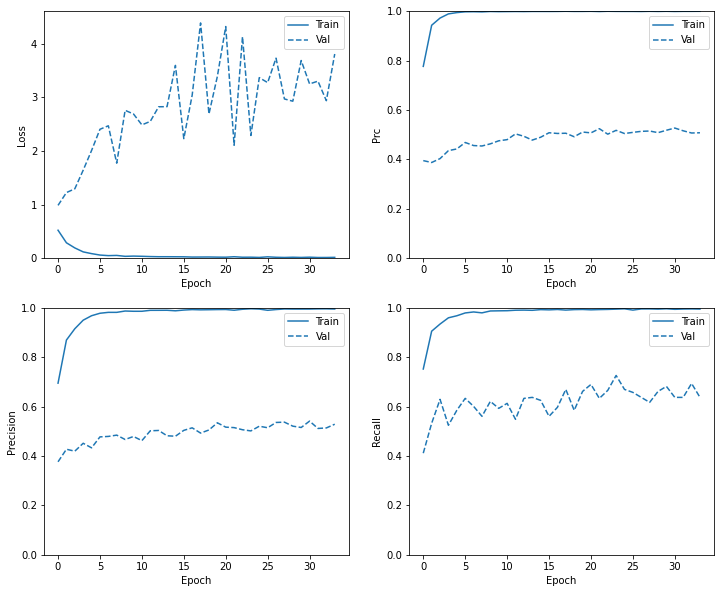

In [67]:
plot_metrics(resampled_history)


In [68]:
train_predictions_resampled = resampled_model.predict(
    X_train, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(
    X_test, batch_size=BATCH_SIZE)


23/23 [==============================] - 0s 14ms/step


loss :  2.2744522094726562
tp :  180.0
fp :  179.0
tn :  301.0
fn :  68.0
accuracy :  0.6607142686843872
precision :  0.5013927817344666
recall :  0.725806474685669
auc :  0.6966355443000793
prc :  0.5045056343078613

Legitimate Transactions Detected (True Negatives):  303
Legitimate Transactions Incorrectly Detected (False Positives):  177
Fraudulent Transactions Missed (False Negatives):  72
Fraudulent Transactions Detected (True Positives):  176
Total Fraudulent Transactions:  248


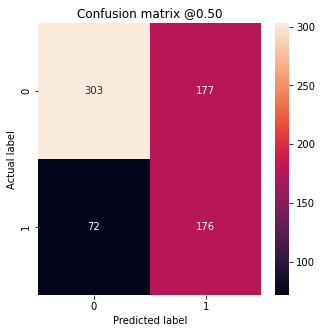

In [69]:
resampled_results = resampled_model.evaluate(X_test, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_resampled)


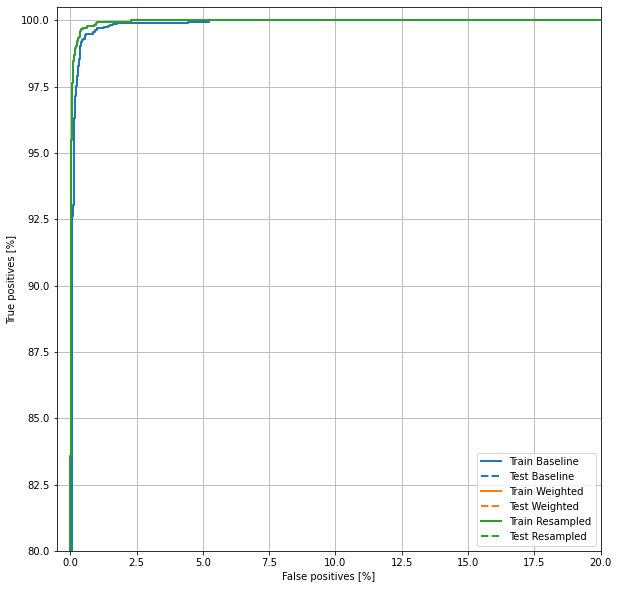

In [70]:
plot_roc("Train Baseline", y_train,
         train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline,
         color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train,
         train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted,
         color=colors[1], linestyle='--')

plot_roc("Train Resampled", y_train,
         train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", y_test, test_predictions_resampled,
         color=colors[2], linestyle='--')
plt.legend(loc='lower right')


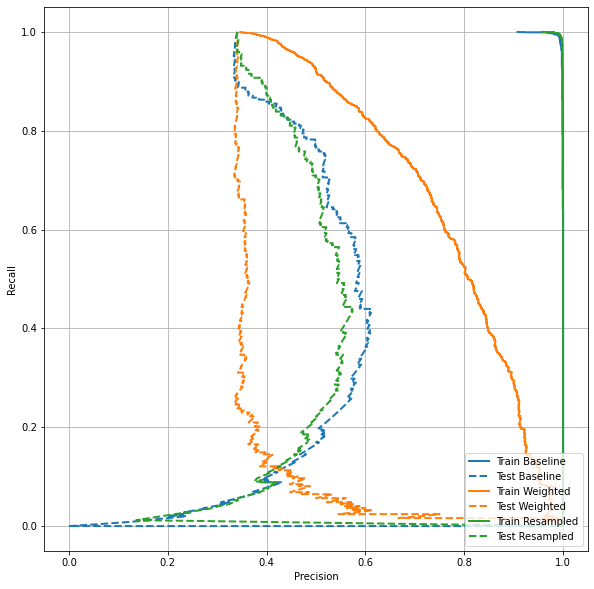

In [71]:
plot_prc("Train Baseline", y_train,
         train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline,
         color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train,
         train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted,
         color=colors[1], linestyle='--')

plot_prc("Train Resampled", y_train,
         train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", y_test, test_predictions_resampled,
         color=colors[2], linestyle='--')
plt.legend(loc='lower right')
